In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# do the same for arima results
arima_results = pd.read_csv('../datasets/sarimax_results.csv', index_col = False)
arima_results['y_test'] = arima_results['y_test'].str.replace("[","").str.replace("]","").str.strip().str.split(",")
arima_results['y_pred'] = arima_results['y_pred'].str.replace("[","").str.replace("]","").str.strip().str.split(",")
# Filter rows where lengths of y_test and y_pred are not equal
arima_results = arima_results[arima_results['y_test'].str.len() == arima_results['y_pred'].str.len()]
#this is valid because all the ones that are unequal are the ones where y_test was empty and the predictions were nan

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def extend_data(data):
    extended_data = []
    for index, row in data.iterrows():
        y_test_values = row['y_test']
        y_pred_values = row['y_pred']
        assert len(y_test_values) == len(y_pred_values)
        for i in range(len(y_test_values)):
            new_row = {
                'Sensor Index': row['Sensor Index'],
                'Latitude': row['Latitude'],
                'Longitude': row['Longitude'],
                'y_test': y_test_values[i],
                'y_pred': y_pred_values[i]
            }
            extended_data.append(new_row)
    return pd.DataFrame(extended_data)

expanded_arima_results = extend_data(arima_results)

In [10]:
# filter out hte rows where y_test > 100
expanded_arima_results['y_test'] = expanded_arima_results['y_test'].astype(float)
expanded_arima_results['y_pred'] = expanded_arima_results['y_pred'].astype(float)
expanded_arima_results = expanded_arima_results[expanded_arima_results['y_test'] < 60]
# filter out the rows where y_pred > 100
expanded_arima_results = expanded_arima_results[expanded_arima_results['y_pred'] < 60]

In [11]:

start_date = '2024-01-08'

def add_datetime(group):
    num_rows = len(group)
    group['datetime'] = pd.date_range(start=start_date, periods=num_rows)
    return group

# for arima results
arima_results_with_datetime = expanded_arima_results.groupby('Sensor Index', as_index = False).apply(add_datetime)
arima_results_with_datetime.reset_index(drop=True, inplace=True)

/tmp/ipykernel_1666350/4289783599.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  arima_results_with_datetime = expanded_arima_results.groupby('Sensor Index', as_index = False).apply(add_datetime)


In [12]:
# errors in arima predictions
def calculate_errors(row):
    mae = mean_absolute_error([row['y_test']], [row['y_pred']])
    mse = mean_squared_error([row['y_test']], [row['y_pred']])
    rmse = np.sqrt(mse)
    return pd.Series({'MAE': mae, 'MSE': mse, 'RMSE': rmse})

arima_results_with_datetime['y_test'] = arima_results_with_datetime['y_test'].astype(float)
arima_results_with_datetime['y_pred'] = arima_results_with_datetime['y_pred'].astype(float)
arima_predictions_errors = arima_results_with_datetime.apply(calculate_errors, axis = 1)
arima_results_with_errors = pd.concat([arima_results_with_datetime, arima_predictions_errors], axis = 1)

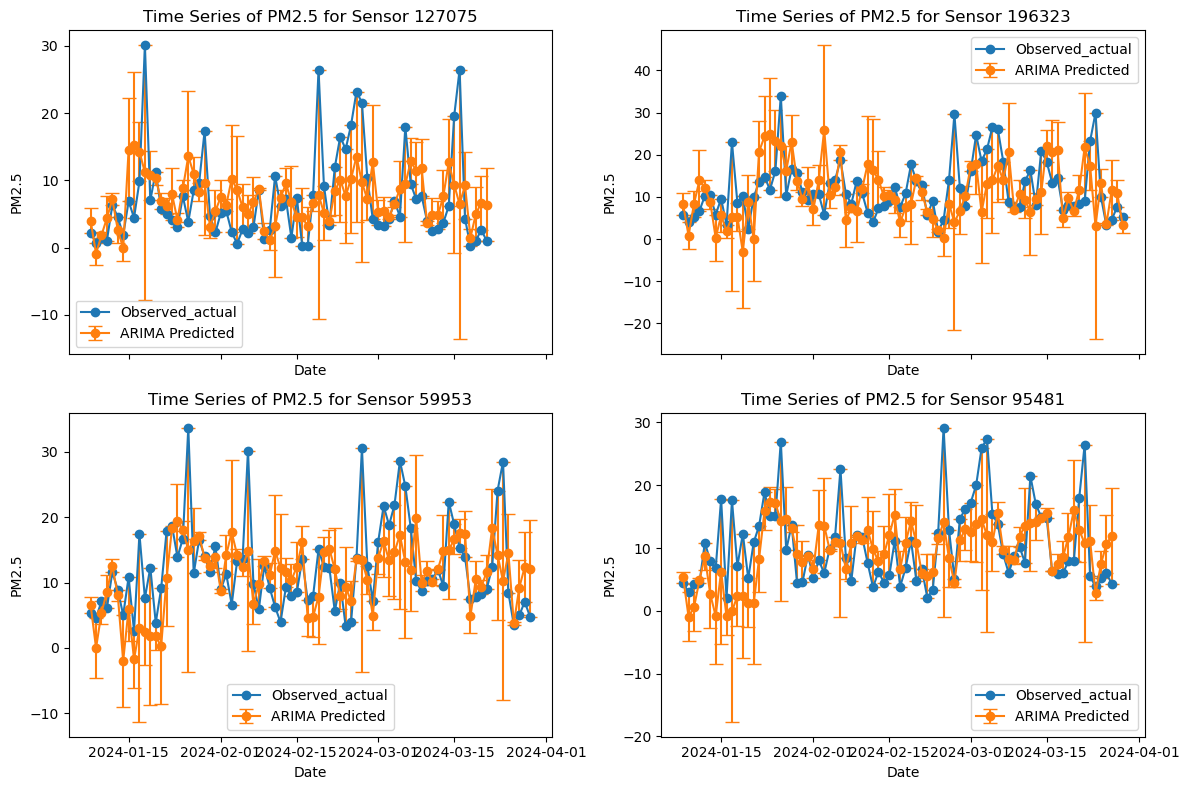

In [13]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Select 4 random sensor IDs
random_sensor_ids = np.random.choice(arima_results_with_errors['Sensor Index'].unique(), 4, replace=False)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the chosen sensor IDs and plot
for i, sensor_id in enumerate(random_sensor_ids):
    ax = axes[i]
    df_sensor = arima_results_with_errors[arima_results_with_errors['Sensor Index'] == sensor_id]

    ax.errorbar(df_sensor['datetime'], df_sensor['y_test'], fmt='-o', label='Observed_actual', capsize=5)
    ax.errorbar(df_sensor['datetime'], df_sensor['y_pred'], yerr=df_sensor['RMSE'], fmt='-o', label='ARIMA Predicted', capsize=5)

    ax.set_xlabel('Date')
    ax.set_ylabel('PM2.5')
    ax.set_title(f'Time Series of PM2.5 for Sensor {sensor_id}')
    ax.legend()

# Remove empty subplots
for j in range(len(random_sensor_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Not adequate. RMSE errors are significantly large.

In [14]:
spatial_results_xgboost = pd.read_csv('../datasets/spatial_results.csv', index_col=False)
temporal_results_xgboost = pd.read_csv('../datasets/temporal_results.csv', index_col = False)
temporal_results_xgboost['y_test'] = temporal_results_xgboost['y_test'].str.replace("[","").str.replace("]","").str.strip().str.split(",")
temporal_results_xgboost['y_pred'] = temporal_results_xgboost['y_pred'].str.replace("[","").str.replace("]","").str.strip().str.split(",")
# Filter rows where lengths of y_test and y_pred are not equal
temporal_results_xgboost = temporal_results_xgboost[temporal_results_xgboost['y_test'].str.len() == temporal_results_xgboost['y_pred'].str.len()]

#this is valid because all the ones that are unequal are the ones where y_test was empty and the predictions were nan
expanded_temporal_results = extend_data(temporal_results_xgboost)
# filter out hte rows where y_test > 100
expanded_temporal_results['y_test'] = expanded_temporal_results['y_test'].astype(float)
expanded_temporal_results['y_pred'] = expanded_temporal_results['y_pred'].astype(float)
expanded_temporal_results = expanded_temporal_results[expanded_temporal_results['y_test'] < 100]
# filter out the rows where y_pred > 100
expanded_temporal_results = expanded_temporal_results[expanded_temporal_results['y_pred'] < 100]
# for xgboost results
temporal_results_with_datetime = expanded_temporal_results.groupby('Sensor Index', as_index = False).apply(add_datetime)
temporal_results_with_datetime.reset_index(drop=True, inplace=True)

/tmp/ipykernel_1666350/3370733476.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temporal_results_with_datetime = expanded_temporal_results.groupby('Sensor Index', as_index = False).apply(add_datetime)


In [15]:
# merge spatial regression with temporal regression
spatial_results_xgboost['Date'] = pd.to_datetime(spatial_results_xgboost['Date'])
spatio_temporal_prediction = pd.merge(temporal_results_with_datetime, spatial_results_xgboost, 
                                      left_on = ["Sensor Index",'datetime'], 
                                      right_on = ["Sensor Index", "Date"], 
                                      how = "inner",
                                      suffixes = ('_temporal', '_spatial')
                                      )

spatio_temporal_prediction['y_test'] = spatio_temporal_prediction['y_test'].astype(float)

spatio_temporal_prediction = spatio_temporal_prediction[spatio_temporal_prediction['Y Test'] != 0]

spatio_temporal_prediction = spatio_temporal_prediction[spatio_temporal_prediction['y_test'] == spatio_temporal_prediction['Y Test']] # Only keep rows where the y_test values are the same

spatio_temporal_predictions_filtered = spatio_temporal_prediction[["datetime", "Sensor Index", "Latitude", "Longitude", "y_test", "y_pred", "Y Pred"]].rename(
    columns = {"y_pred": "y_pred_temporal",
               "Y Pred": "y_pred_spatial"}) # Rename columns
spatio_temporal_predictions_filtered['y_pred_temporal'] = pd.to_numeric(spatio_temporal_predictions_filtered['y_pred_temporal'], errors='coerce')
spatio_temporal_predictions_filtered['y_pred_spatial'] = pd.to_numeric(spatio_temporal_predictions_filtered['y_pred_spatial'], errors='coerce')

spatio_temporal_predictions_filtered['y_pred_ensemble'] = (spatio_temporal_predictions_filtered['y_pred_temporal']+spatio_temporal_predictions_filtered['y_pred_spatial'] )/2

In [16]:
spatio_temporal_predictions_filtered

,datetime,Sensor Index,Latitude,Longitude,y_test,y_pred_temporal,y_pred_spatial,y_pred_ensemble
0,2024-01-08,2644.0,32.990840,-96.59930,4.567,4.588784,2.914640,3.751712
1,2024-01-09,2644.0,32.990840,-96.59930,2.942,1.441071,1.168769,1.304920
2,2024-01-10,2644.0,32.990840,-96.59930,5.189,6.014292,2.096690,4.055491
3,2024-01-11,2644.0,32.990840,-96.59930,6.350,6.064746,2.563947,4.314347
4,2024-01-12,2644.0,32.990840,-96.59930,9.423,7.412156,9.274713,8.343434
...,...,...,...,...,...,...,...,...
4673,2024-03-25,196421.0,32.977444,-96.77611,8.486,8.816689,4.093846,6.455267
4674,2024-03-26,196421.0,32.977444,-96.77611,2.979,6.820067,3.973480,5.396774
4675,2024-03-27,196421.0,32.977444,-96.77611,3.645,4.269077,4.406744,4.337911
4676,2024-03-28,196421.0,32.977444,-96.77611,5.956,4.852806,4.822787,4.837796


In [17]:
def calculate_errors(row):
    mse = mean_squared_error([row['y_test']], [row['y_pred_ensemble']])
    rmse = np.sqrt(mse)
    return pd.Series({'MSE': mse, 'RMSE': rmse})

errors_spatio_temporal = spatio_temporal_predictions_filtered.apply(calculate_errors, axis = 1)
spatio_temporal_predictions_with_errors = pd.concat([spatio_temporal_predictions_filtered, errors_spatio_temporal], axis = 1)

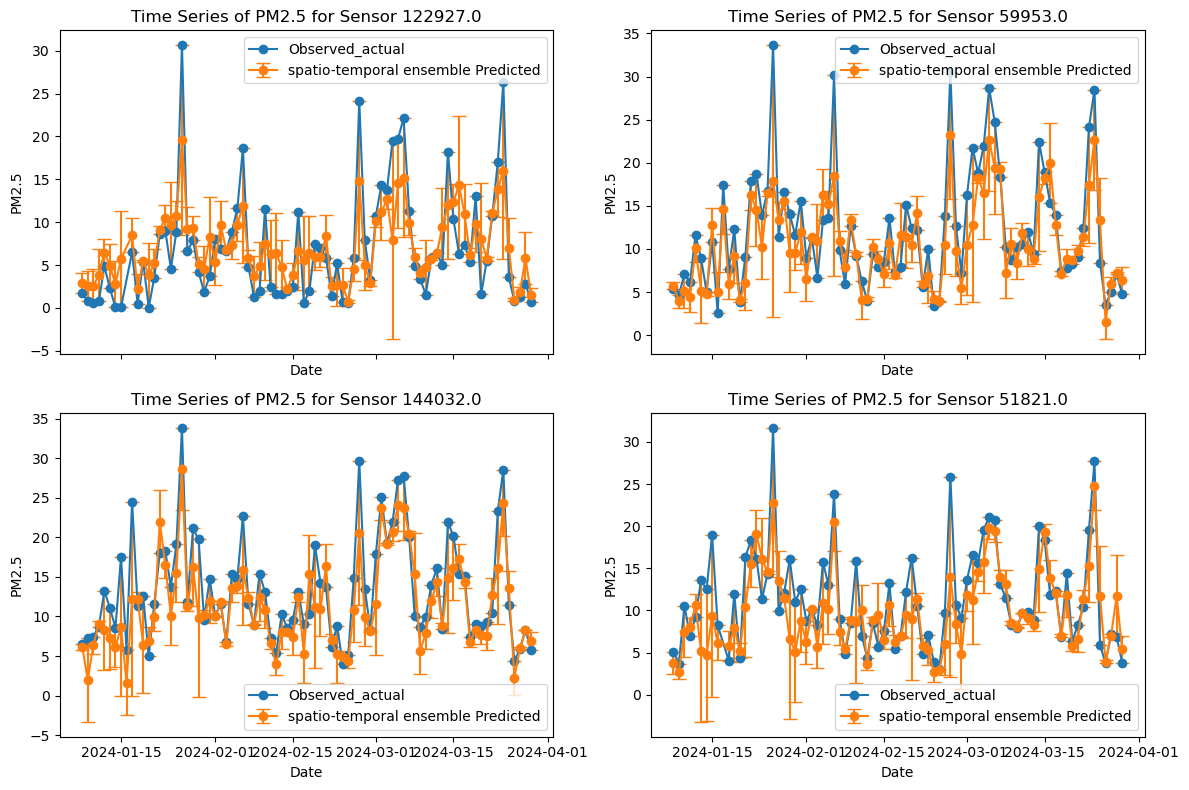

In [23]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Select 4 random sensor IDs
random_sensor_ids = np.random.choice(spatio_temporal_predictions_with_errors['Sensor Index'].unique(), 4, replace=False)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the chosen sensor IDs and plot
for i, sensor_id in enumerate(random_sensor_ids):
    ax = axes[i]
    df_sensor = spatio_temporal_predictions_with_errors[spatio_temporal_predictions_with_errors['Sensor Index'] == sensor_id]

    ax.errorbar(df_sensor['datetime'], df_sensor['y_test'], fmt='-o', label='Observed_actual', capsize=5)
    ax.errorbar(df_sensor['datetime'], df_sensor['y_pred_ensemble'], yerr=df_sensor['RMSE'], fmt='-o', label='spatio-temporal ensemble Predicted', capsize=5)

    ax.set_xlabel('Date')
    ax.set_ylabel('PM2.5')
    ax.set_title(f'Time Series of PM2.5 for Sensor {sensor_id}')
    ax.legend()

# Remove empty subplots
for j in range(len(random_sensor_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

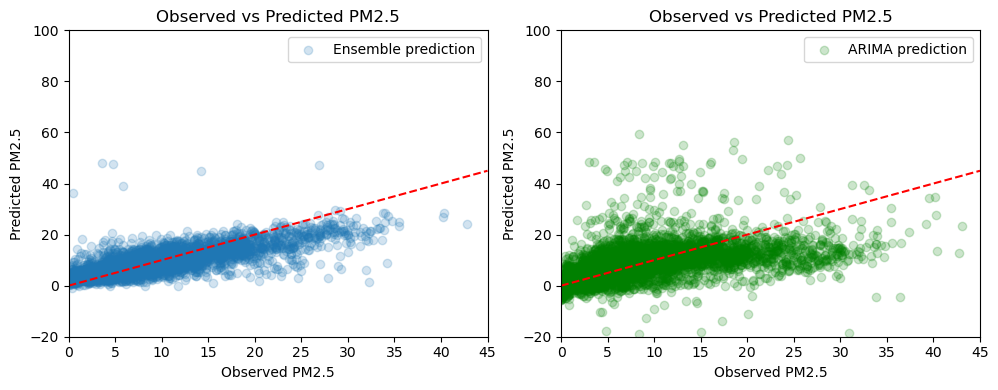

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].scatter(spatio_temporal_predictions_with_errors['y_test'],spatio_temporal_predictions_with_errors['y_pred_ensemble'], label='Ensemble prediction', alpha=0.2)
ax[0].plot([0, 45], [0, 45], color='red', linestyle='--')
ax[0].set_xlim(0, 45)
ax[0].set_ylim(-20, 100)
ax[0].set_xlabel('Observed PM2.5')
ax[0].set_ylabel('Predicted PM2.5')
ax[0].set_title('Observed vs Predicted PM2.5')
ax[0].legend()


ax[1].scatter(arima_results_with_errors['y_test'], arima_results_with_errors['y_pred'], label='ARIMA prediction', alpha=0.2, color='green')
ax[1].plot([0, 45], [0, 45], color='red', linestyle='--')
ax[1].set_xlim(0, 45)
ax[1].set_ylim(-20, 100)
ax[1].set_xlabel('Observed PM2.5')
ax[1].set_ylabel('Predicted PM2.5')
ax[1].set_title('Observed vs Predicted PM2.5')
ax[1].legend()

plt.tight_layout()
plt.show()

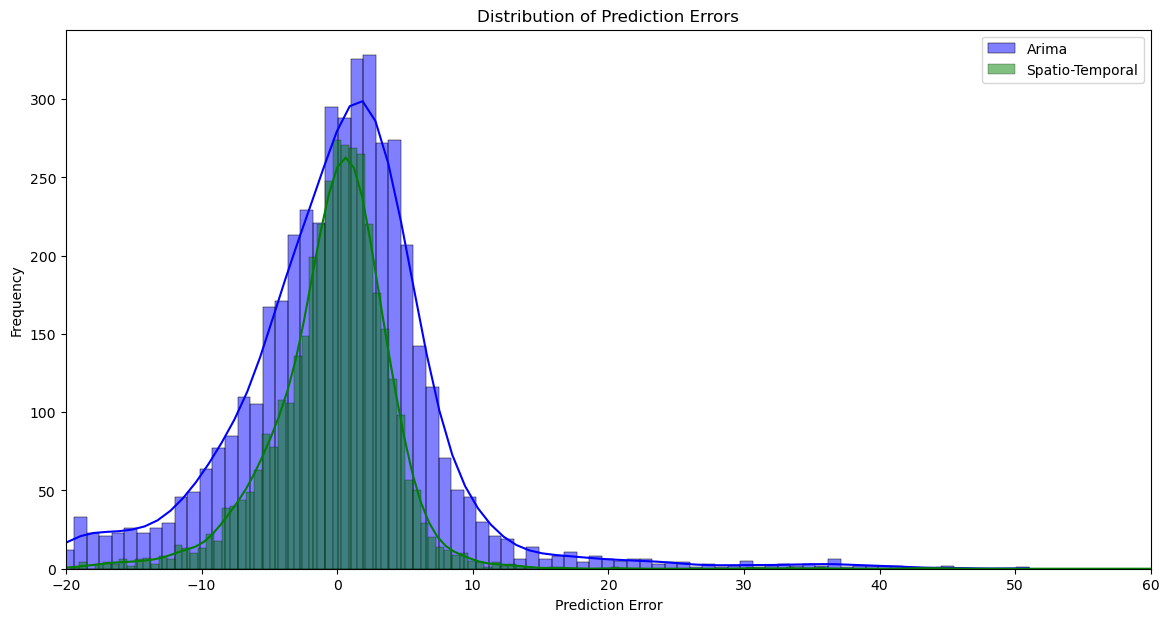

In [22]:
import seaborn as sns

# Calculate errors
arima_results_with_errors['Error_spatio_temporal'] = arima_results_with_errors['y_pred'] -arima_results_with_errors['y_test']
spatio_temporal_predictions_with_errors['Error_spatio_temporal'] = spatio_temporal_predictions_with_errors['y_pred_ensemble'] -spatio_temporal_predictions_with_errors['y_test']

plt.figure(figsize=(14, 7))
sns.histplot(arima_results_with_errors['Error_spatio_temporal'], color='blue', label='Arima', kde=True, alpha=0.5)
sns.histplot(spatio_temporal_predictions_with_errors['Error_spatio_temporal'], color='green', label='Spatio-Temporal', kde=True, alpha=0.5)
plt.xlabel('Prediction Error')
plt.xlim(-20,60)
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.show()
